In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
import matplotlib.patches as patches
from scipy.ndimage.filters import gaussian_filter as gf

from hyss_util import *

In [2]:
# -- matplotlib defaults
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

In [3]:
# -- load both 2013 and 2018 scan
imgL_hsi0_half0 = np.load("../output/filtered_hsi0_half0.npy")
imgL_hsi0_half1 = np.load("../output/filtered_hsi0_half1.npy")
hsi0 = np.hstack([imgL_hsi0_half0, imgL_hsi0_half1])

imgL_hsi1_half0 = np.load("../output/filtered_hsi1_half0.npy")
imgL_hsi1_half1 = np.load("../output/filtered_hsi1_half1.npy")
hsi1 = np.hstack([imgL_hsi1_half0, imgL_hsi1_half1])

In [4]:
# -- get mean brightness images and save them if necessary
fnameL0 = "../output/hsi0_filter_mean.npy"
fnameL1 = "../output/hsi1_filter_mean.npy"

if os.path.isfile(fnameL0):
    imgL_hsi0 =  np.load(fnameL0)
else:
    print("{0} not found!  creating and writing...".format(fnameL0))
    imgL_hsi0 = hsi0.mean(axis=0)
    np.save(fnameL0, imgL_hsi0)

if os.path.isfile(fnameL1):
    imgL_hsi1 =  np.load(fnameL1)
else:
    print("{0} not found!  creating and writing...".format(fnameL1))
    imgL_hsi0 = hsi0.mean(axis=0)
    np.save(fnameL1, imgL_hsi1)

In [5]:
# -- get the overlapping area
img_L1 = (resize(imgL_hsi1.astype(float), (695, 1252)))[:, 165:1252]
img_L0 = imgL_hsi0[238:933, 0:1087]
nrow, ncol = img_L0.shape

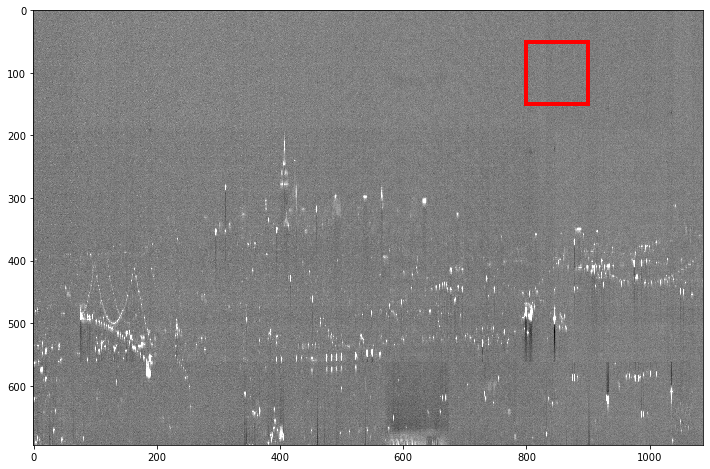

In [6]:
# -- plot luminosity
fig, ax = plt.subplots(figsize = (12, 8))
ax.imshow(img_L0, interpolation="nearest", aspect="auto", clim=[-3, 3])
rect = patches.Rectangle((800, 50), 100, 100, linewidth=4, edgecolor='red', facecolor='none')
ax.add_patch(rect)

In [25]:
# -- calculate the slope and offset for sensor sensitivity correction and apply Gaussian noise
patch_L1 = img_L1[420:465, 150:200].flatten().clip(-5, 5)
patch_L0 = img_L0[420:465, 150:200].flatten().clip(-5, 5)

sig = 0.21
slp, off = np.polyfit(patch_L1, patch_L0, 1)

np.random.seed(302)
img3 = img_L1 * slp + off + np.random.randn(nrow, ncol) * sig

patch_L0_2 = img_L0[420:465, 150:200]
patch_i3_2 = img3[420:465, 150:200]
# # -- save reshaped imgL0 and imgL3
# np.save("../output/graham_hall_upload/imgL0_overlap.npy", img_L0)
# #np.save("../output/img3_overlap.npy", img3)

# # -- we load img3 here because the number of sources calculate by above formula will have some differences
# img3 = np.load("../output/img3_overlap.npy")

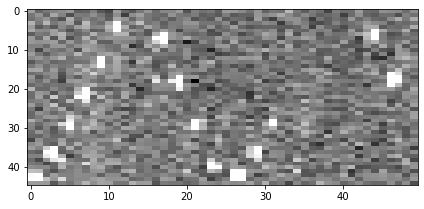

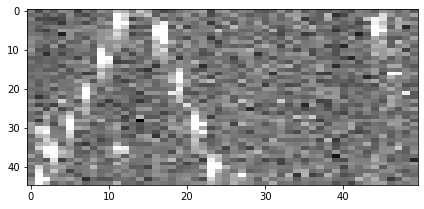

In [26]:
# plt.imshow(0.25 * img_L1[420:465, 150:200] - 0.0016 + np.random.randn(45, 50) * 0.19, aspect=0.5, clim=[-1, 4.5])
plt.imshow(img3[420:465, 150:200], aspect=0.5, clim=[-1, 1])

plt.figure()
plt.imshow(img_L0[420:465, 150:200], aspect=0.5, clim=[-1, 1])

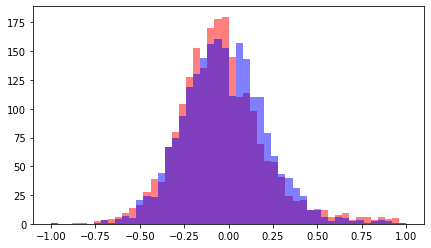

In [21]:
h = plt.hist(patch_L0_2.flatten(), bins=50, range=[-1, 1], alpha=0.5, color="red")
h = plt.hist(patch_i3_2.flatten(), bins=50, range=[-1, 1], alpha=0.5, color="blue")

In [217]:
# # -- this is for the sky
# # -- calculate the slope and offset for sensor sensitivity correction
# slp, off = np.polyfit(img_L1[50:150, 800:900].flatten().clip(-5, 5), img_L0[50:150, 800:900].flatten().clip(-5, 5), 1)
# img3 = img_L1 * slp + off + np.random.randn(nrow, ncol) * 0.18

# # -- save reshaped imgL3 and imgL3
# np.save("../output/imgL0_overlap_sky.npy", img3)


# # -- we load img3 here because the number of sources calculate by above formula will have some differences
# img3 = np.load("../output/imgL0_overlap_sky.npy")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


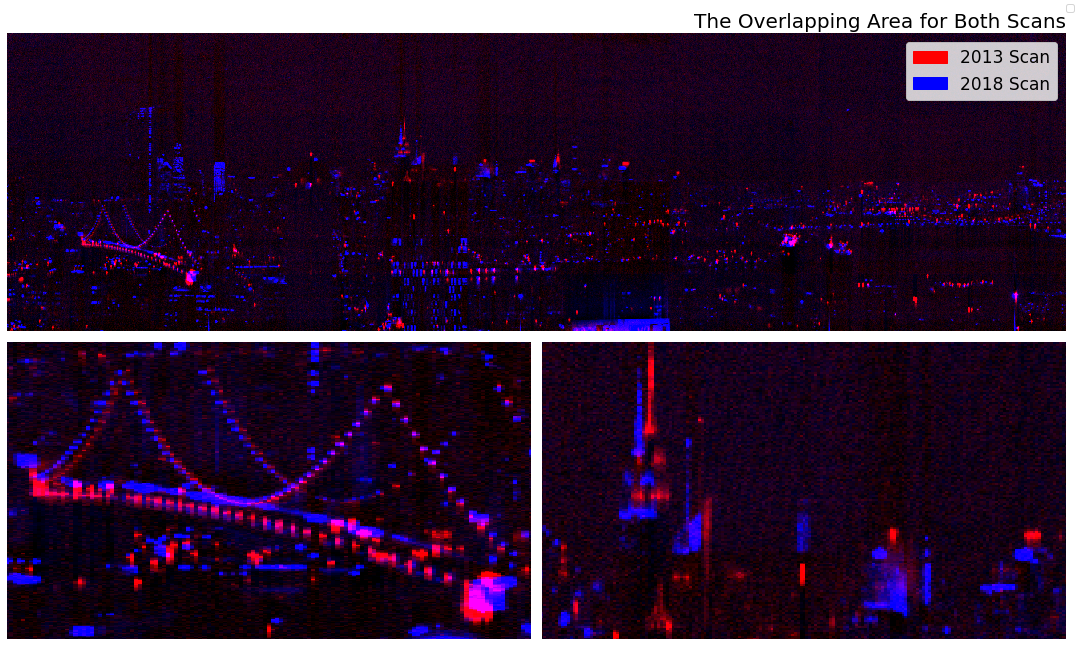

In [13]:
# -- create a 3-channel image

# -- make a 3-channel image
red = (img_L0.clip(-5, 5) + 5) / 10
blu = (img_L1.clip(-5, 5) + 5) / 10
rgb = np.dstack((red, np.zeros_like(red), blu))

rgb = (3*rgb - 1.4).clip(0, 1)


fig, ax = plt.subplots(figsize=(15, 9))

ax1 = plt.subplot(2,1,1)
ax1.imshow(rgb, interpolation="nearest", aspect="auto")
ax1.set_title("The Overlapping Area for Both Scans", loc='right', fontsize=20)
ax2 = plt.subplot(2,2,3)
ax3 = plt.subplot(2,2,4)
ax2.imshow(rgb, interpolation="nearest", aspect="auto")
ax3.imshow(rgb, interpolation="nearest", aspect="auto")
# ax[2].imshow(rgb, interpolation="nearest", aspect="auto")
ax2.set_ylim(600, 380)
ax2.set_xlim(70, 200)
ax3.set_ylim(350, 200)
ax3.set_xlim(370, 550)

axes = [ax1, ax2, ax3]
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
fig.legend()# add legend, upper right 
fig.tight_layout()

df_legend = pd.DataFrame([
                          [0, [255, 0, 0], '2013 Scan'],
                            [1, [0, 0, 255], '2018 Scan'],
    
                          ],
                         columns=['key', 'color', 'name'])

handles_1 = [patches.Rectangle((0, 0), 1, 1, color=[c / 255 for c in color_list]) for color_list in df_legend['color']]
labels = df_legend['name']

ax1.legend(handles_1, labels, loc='upper right', ncol=1, fontsize=17)

fig.tight_layout()

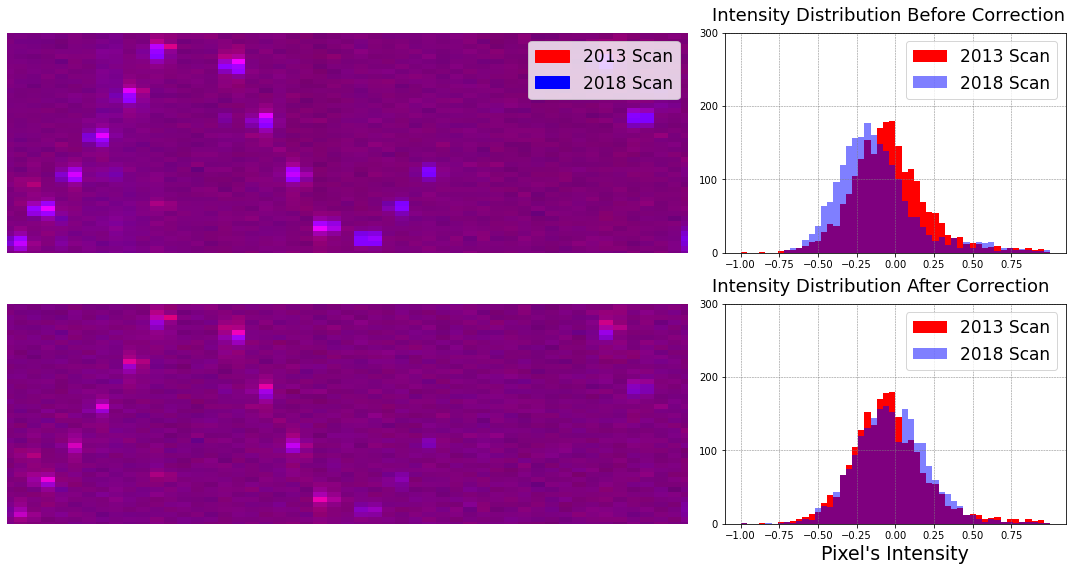

In [27]:
# -- make a 3-channel image (this is after sensor sensitivity correction)
red1 = (img_L0.clip(-5, 5) + 5) / 10
blu1 = (img3.clip(-5, 5) + 5) / 10

rgb = np.dstack((red, np.zeros_like(red), blu))
rgb1 = np.dstack((red1, np.zeros_like(red1), blu1))

rgb = np.dstack((red, np.zeros_like(red), blu))
rgb1 = np.dstack((red1, np.zeros_like(red1), blu1))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 8), gridspec_kw={'width_ratios': [2, 1]})


ax[0, 0].imshow(rgb, interpolation="nearest", aspect="auto")
ax[1, 0].imshow(rgb1, interpolation="nearest", aspect="auto")
ax[0, 0].axis('off')
ax[1, 0].axis('off')

ax[0, 0].set_ylim(465, 420)
ax[0, 0].set_xlim(150, 200)

ax[1, 0].set_ylim(465, 420)
ax[1, 0].set_xlim(150, 200)


ax[0, 1].hist(patch_L0_2.flatten(), bins=50, range = (-1, 1), color = "red")
ax[0, 1].hist(img_L1[420:465, 150:200].flatten(), bins=50,  range = (-1, 1), alpha=0.5, color = "blue");
ax[0, 1].grid(color = 'grey', linestyle = '--', linewidth = 0.5)

ax[1, 1].hist(patch_L0_2.flatten(), bins=50,  range = (-1, 1), color = "red")
ax[1, 1].hist(patch_i3_2.flatten(), bins=50, alpha=0.5,range = (-1, 1),  color = "blue");
ax[1, 1].grid(color = 'grey', linestyle = '--', linewidth = 0.5)
fig.text(0.663, 0.97, 'Intensity Distribution Before Correction', va='center', fontsize = 18)
fig.text(0.663, 0.50, 'Intensity Distribution After Correction', va='center', fontsize = 18)
fig.subplots_adjust(hspace=8)


ax[0, 1].legend(['2013 Scan', '2018 Scan'], fontsize=17)
ax[1, 1].legend(['2013 Scan', '2018 Scan'], fontsize=17)
ax[0, 1].set_yticks(np.arange(0, 400, 100))
ax[1, 1].set_yticks(np.arange(0, 400, 100))
ax[0, 1].set_xticks(np.arange(-1, 1, 0.25))
ax[1, 1].set_xticks(np.arange(-1, 1, 0.25))
ax[1, 1].set_xlabel("Pixel's Intensity", fontsize=19)

df_legend = pd.DataFrame([
                          [0, [255, 0, 0], '2013 Scan'],
                            [1, [0, 0, 255], '2018 Scan'],
    
                          ],
                         columns=['key', 'color', 'name'])

handles_1 = [patches.Rectangle((0, 0), 1, 1, color=[c / 255 for c in color_list]) for color_list in df_legend['color']]
labels = df_legend['name']

ax[0, 0].legend(handles_1, labels, loc='upper right', ncol=1, fontsize=17,)

fig.tight_layout()

In [207]:
# -- get active source location and spec for both 2013 and 2018 hyperspectral scan
# -- if raw file exists, read it, create file if not
dname = "../output/hsi0_overlap_cnn_allwave_bridge.npy" 

if os.path.isfile(dname):

  print("Active source file for the 2013 scan is existed")

else:
  dpath0 = os.path.join(os.environ["LTCO_HSI0"], "full frame 20ms faster_VNIR.raw")
  # -- read 2013 scan and then get raw spectra data for these sources
  cube = read_hyper(dpath0)

  # -- manually set threshold and apply gf
  imgL0_gf = gf(1.0 * (img_L0 > 0.7), 1) > 0.25
  imgL0_overlap = 1.0 * np.array(imgL0_gf)

  # -- get raw spec data for 'active' pixel
  img_data = cube.data

  spec = []
  for i in range(len(img_data)):
    spec.append(img_data[i][238:933, 0:1087][imgL0_gf])

  spec = np.vstack(spec)
  np.save("../output/hsi0_overlap_cnn_allwave_bridge.npy", spec)


  # -- get location for 'active' pixel and  save it
  hsi0_indices = np.argwhere(imgL0_overlap == 1)
  hsi0_indices


  np.save("../output/hsi0_overlap_location_bridge.npy", hsi0_indices)


reading and parsing full frame 20ms faster_VNIR.hdr...
reading full frame 20ms faster_VNIR.raw...


In [223]:
# -- if raw file exists, read it, create file if not
dname = "../../output/hsi1_overlap_cnn_allwave_brdge.npy" 

if os.path.isfile(dname):

  print("Active source file for the 2018 scan is existed")

else: 
 
  # -- read 2018 scan and then get raw spectra data for these sources
  dpath = os.path.join(os.environ["LTCO_HSI1"], "night_00000.raw")
  cube = read_hyper(dpath)

  # -- manually set threshold and apply gf
  imgL1_gf = gf(1.0 * (img3 > 0.7), 1) > 0.25
  imgL1_overlap = 1.0 * np.array(imgL1_gf)

  # -- get raw spec data for 'active' pixel
  img_data = cube.data

  spec = []
  for i in range(len(img_data)):
    spec.append(((resize(img_data[i], (695, 1252)))[:, 165:1252])[imgL1_gf])

  spec = np.vstack(spec)
  np.save("../output/hsi1_overlap_cnn_allwave_bridge.npy", spec)


  # -- get location for 'active' pixel and then save it
  hsi1_indices = np.argwhere(imgL1_overlap == 1)

  np.save("../output/hsi1_overlap_location_bridge.npy", hsi1_indices)

reading and parsing night_00000.hdr...
reading night_00000.raw...


In [208]:
spec = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy")
spec.shape

(872, 15075)

In [224]:
spec = np.load("../output/hsi1_overlap_cnn_allwave_bridge.npy")
spec.shape

(848, 16167)

In [ ]:
16310